# Mandatory assignment 2: Solow growth model with human capital
Vision: Programming is more than writing code. The ultimate goal of the projects in this course
is that you learn to formulate a programming problem of your own choice, and find your own way
to solve it, and present the results. The bullets below are minimum requirements, but otherwise it is
very much up to you, what yo

* **Step 1: Package import:** The first part of code in our project is the use of libraries with essential packages of panda, numpy and glob which is respectively for data structuring and especially arrays and pathnames. On top of that we import statsmodel

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
import sympy as sm
sm.init_printing(use_unicode=True)
from scipy import optimize
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
from IPython.display import display
from IPython.display import Image
import statsmodels.api as statm
import statsmodels.formula.api as smf
from sympy import symbols, Eq, solve
import turtle

* **Step 2: Datapath and data processing:** Our data p

In [18]:
#Set datapath 
datapath = "Dataset/"
data = pd.read_excel(datapath + "APPENDIX_TableA_SECOND_ED-7.xls")

#Remove unnecessary rows
data=data[14:-18]
#Remove unnecessary columns
data = data.iloc[:, :-3]

#Mark/select first row
new_header = data.iloc[0]
#all data below first row
data = data[1:] 
#use all data below first row and set column names equal new_header
data.columns = new_header

data.rename(columns = {list(data)[0]:"Country"}, inplace=True)
                                                    
data.head()

14,Country,Code,y03,y60,gy,sK,sH,u,isi,n,Grade,In Sample of 65
15,Luxembourg,LUX,1.73518,0.966286,0.0313231,0.255914,-,-,0.9,0.00836579,A,0
16,USA,USA,1,1,0.017709,0.189912,0.115346,12.049,0.97333,0.0160803,A,1
17,Ireland,IRL,0.971402,0.423321,0.0370255,0.209641,0.125219,9.351,0.76672,0.0100189,A,1
18,Norway,NOR,0.968075,0.761374,0.0232946,0.283681,0.103698,11.848,0.87272,0.0122046,A,1
19,Belgium,BEL,0.906815,0.66365,0.024969,0.224658,0.101057,9.338,0.86572,0.00450328,A,1


We now merge data on land per worker and Oil per worker on the above dataset

In [19]:
datapath1 = "Dataset/"
data1 = pd.read_excel(datapath1 + "Natural_resources_the_world_bank.xlsx")

data3 = pd.merge(data, data1, on="Code")

data3.head(100)

,Country_x,Code,y03,y60,gy,sK,sH,u,isi,n,Grade,In Sample of 65,Country_y,Land,Subsoil
0,Luxembourg,LUX,1.73518,0.966286,0.0313231,0.255914,-,-,0.9,0.00836579,A,0,Luxembourg,5600.667027,1988.652571
1,USA,USA,1,1,0.017709,0.189912,0.115346,12.049,0.97333,0.0160803,A,1,United States,4268.678035,8651.206146
2,Ireland,IRL,0.971402,0.423321,0.0370255,0.209641,0.125219,9.351,0.76672,0.0100189,A,1,Ireland,11973.825063,367.476245
3,Norway,NOR,0.968075,0.761374,0.0232946,0.283681,0.103698,11.848,0.87272,0.0122046,A,1,Norway,6372.783293,83250.768105
4,Austria,AUT,0.880988,0.554981,0.0284557,0.24048,0.0951991,8.354,0.86356,0.00244029,A,1,Austria,5163.836552,1007.211843
5,France,FRA,0.838556,0.622969,0.0246202,0.230761,0.0950759,-,0.87067,0.0073631,A,1,France,5071.818298,80.680915
6,Netherlands,NLD,0.836797,0.908967,0.0157851,0.241691,0.113188,9.355,0.894,0.0135367,A,1,Netherlands,4552.174485,4223.863318
7,Australia,AUS,0.80454,0.83725,0.0167821,0.243485,0.102077,10.922,0.80978,0.0206104,A,1,Australia,16059.600939,115042.535079
8,Italy,ITA,0.767651,0.546664,0.0256043,0.242707,0.0747032,7.18,0.80767,0.00479002,A,1,Italy,5487.171525,526.645361
9,United Kingdom,GBR,0.765101,0.704924,0.019614,0.174096,0.0935279,9.42,0.85556,0.00516157,A,1,United Kingdom,2230.067654,3005.352140


In [20]:
DataDescribe=data3
DataDescribe = DataDescribe.drop(["Code", "In Sample of 65", "u", "isi", "Country_y"], 1)

DataDescribe=DataDescribe[DataDescribe["sH"] != '   -']


DataDescribe["y03"] = DataDescribe.y03.astype(float)
DataDescribe["y60"] = DataDescribe.y60.astype(float)
DataDescribe["gy"] = DataDescribe.gy.astype(float)
DataDescribe["sK"] = DataDescribe.sK.astype(float)
DataDescribe["n"] = DataDescribe.n.astype(float)
DataDescribe["sH"] = DataDescribe.sH.astype(float)
DataDescribe["Land"] = DataDescribe.Land.astype(float)
DataDescribe["Subsoil"] = DataDescribe.Subsoil.astype(float)
#print(DataDescribe.round(decimals=2))

print("")
print("Table 1: Dads")
max =DataDescribe[DataDescribe.y03 == DataDescribe.y03.max()]
display(max.head())

print("")
print("Table 2: sadsaadads ")
min =DataDescribe[DataDescribe.y03 == DataDescribe.y03.min()]
display(min.head())




Table 1: Dads


,Country_x,y03,y60,gy,sK,sH,n,Grade,Land,Subsoil
1,USA,1.0,1.0,0.017709,0.189912,0.115346,0.01608,A,4268.678035,8651.206146



Table 2: sadsaadads 


,Country_x,y03,y60,gy,sK,sH,n,Grade,Land,Subsoil
72,Ethiopia,0.023061,0.026356,0.014604,0.035875,0.014008,0.021697,C,2538.656631,50.165113


In [21]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


print("ksjdkadadjkd sdd sdsd sddsssdd ads  dasadad dkajd sdadjadsddsak sd jksdljasjkaa sdasd dasa da a dad adadasaddsaadsadad adsasdas dssaad asasd ad")

alpha = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.33)
display(alpha)

print("ksjdkadadjkd sdd sdsd sddsssdd ads  dasadad dkajd sdadjadsddsak sd jksdljasjkaa sdasd dasa da a dad adadasaddsaadsadad adsasdas dssaad asasd ad")

beta = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.6)
display(beta)

print("ksjdkadadjkd sdd sdsd sddsssdd ads  dasadad dkajd sdadjadsddsak sd jksdljasjkaa sdasd dasa da a dad adadasaddsaadsadad adsasdas dssaad asasd ad")

epsilon = widgets.FloatSlider(min=0,max=1,step=0.01,value=(1-beta.value-alpha.value)/2)
display(epsilon)

print("ksjdkadadjkd sdd sdsd sddsssdd ads  dasadad dkajd sdadjadsddsak sd jksdljasjkaa sdasd dasa da a dad adadasaddsaadsadad adsasdas dssaad asasd ad")

kilo = widgets.FloatSlider(min=0,max=1,step=0.01,value=(1-beta.value-alpha.value)/2)
display(kilo)

ksjdkadadjkd sdd sdsd sddsssdd ads  dasadad dkajd sdadjadsddsak sd jksdljasjkaa sdasd dasa da a dad adadasaddsaadsadad adsasdas dssaad asasd ad


FloatSlider(value=0.33, max=1.0, step=0.01)

ksjdkadadjkd sdd sdsd sddsssdd ads  dasadad dkajd sdadjadsddsak sd jksdljasjkaa sdasd dasa da a dad adadasaddsaadsadad adsasdas dssaad asasd ad


FloatSlider(value=0.6, max=1.0, step=0.01)

ksjdkadadjkd sdd sdsd sddsssdd ads  dasadad dkajd sdadjadsddsak sd jksdljasjkaa sdasd dasa da a dad adadasaddsaadsadad adsasdas dssaad asasd ad


FloatSlider(value=0.035, max=1.0, step=0.01)

ksjdkadadjkd sdd sdsd sddsssdd ads  dasadad dkajd sdadjadsddsak sd jksdljasjkaa sdasd dasa da a dad adadasaddsaadsadad adsasdas dssaad asasd ad


FloatSlider(value=0.035, max=1.0, step=0.01)

* **Step 3: Steady state value for the augmented Solow model with human capital and natural resources:**

We now set up our **augmented Solow model with human capital and natural resources**, which is given by the parameters:

1. $K_t$ is capital per worker
* $L_t$ is labor (with a growth rate on $n$)
* $A_t$ is technology (growing with a rate of $g$)
* $X_t$ is the total amount of land and it does not carry a time subscript since land is in fixed supply
* $R_t$ is the total remaining stock of an exhaustible resource, oil at time t
* $E_t$ is the part of $R_t$ that is used as energy input during periode t (where the exhaustible rate is $s_E$)
* $Y_t = K_t^\alpha H_t^\varphi(A_tL_t)^\beta X^\kappa E_t^\epsilon$ is GDP

We still have the normal framework for a solow model such that **Savings** is a constant fraction of GDP and the production function have a constant return to scale. Moreover, we are going to use the following equations to model our framwork

8. $R_{t+1} = R_t - E_t$
9. $ E_t = s_E R_t$, where $0<s_E<1$

Dividing the production function by $L_t$ on both sides and using equation 9, gives the production function per worker:

10. $y_t = k_t^\alpha h_t^\varphi A_t^\beta (X/L_t)^\kappa ({s_E R_t}/L_t)^\epsilon $
11. $y_t = k_t^\alpha h_t^\varphi A_t^\beta x_t^\kappa e_t^\epsilon $

SKRIV HER

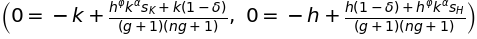

In [27]:
import numpy as np
from scipy.optimize import minimize
import sympy as sm

a = sm.symbols("alpha")
phi = sm.symbols("varphi")
b = sm.symbols("beta")
g = sm.symbols("g")
n = sm.symbols("n")
n = sm.symbols("ng")
y = sm.symbols("y")
d = sm.symbols("delta")
k = sm.symbols("k")
h = sm.symbols("h")
A = sm.symbols("A")
g_y = sm.symbols("g_y")
s_K = sm.symbols("s_K")
s_H = sm.symbols("s_H")
t = sm.symbols("t")

SolowEq = sm.Eq(0,((1/((1+n)*(1+g)))*(s_K*(k**a * (h**phi))+(1-d)*k))-k)

SolowEq1 = sm.Eq(0,((1/((1+n)*(1+g)))*(s_H*(k**a * (h**phi))+(1-d)*h))-h)

SolowEq, SolowEq1


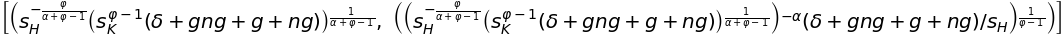

In [28]:
k, h = symbols('k h')

eq1 = Eq(s_K*k**a*h**phi-(n+g+d+(n*g))*k)
eq2 = Eq(s_H*k**a*h**phi-(n+g+d+(n*g))*h)

SS = solve((eq1,eq2), (k, h))
SS

In [29]:
SS1 = sm.lambdify((n, g, s_H, s_K, a, phi, d, h), SS)
SSvalue=SS1(0.01, 0.02, 0.2, 0.2, 0.33, 0.33, 0.05,0.20)
print(SSvalue)

[(14.696788132394444, 14.696788132394442)]


Conducting a numerical solution instead of a analytical solution

In [9]:
n = 0.01
g = 0.02
s_H=0.20
a=0.33
phi=0.33
d=0.05
h=14.697
h=14.696788132394442

# Defining our steady state as a lambda function
SSN = lambda k: 0 - (1/((1+n)*(1+g)))*((s_H*k**a*h**phi-(n+g+d+n*g)*k))

# optimize.newton uses a numerical solution to find a numerical value solution to our steady state
result_SSN = optimize.newton(SSN,x0=100)
result_SSN

In [10]:
k=14.696788132394438
 

# Defining our steady state as a lambda function
SSN1 = lambda h: 0 - (1/((1+n)*(1+g)))*((s_H*k**a*h**phi-(n+g+d+n*g)*h))

# optimize.newton uses a numerical solution to find a numerical value solution to our steady state
result_SSN1 = optimize.newton(SSN1,x0=100)
result_SSN1

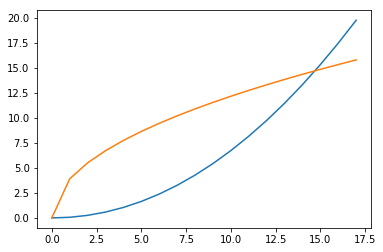

In [127]:
import matplotlib.pyplot as plt
import math  
  
n = 0.01
g = 0.02
s_K = 0.20
a = 0.33
phi =0.33
s_H =0.20
d =0.05


# Create the vectors X and Y
k = np.array(range(18))
h1 = ((((n+g+d+n*g)/(s_K))**(1/phi))*k**((1-a)/phi))
h2 = (((s_H*k**a)/(n+g+d+n*g))**(1/(1-phi)))


# Create the plot
plt.plot(k, h1, h2)

# Show the plot
plt.show()

In [147]:

def phasek(k, s_K, a, phi, n):
    return ((((n+0.02+0.05+n*0.02)/(s_K))**(1/phi))*k**((1-a)/phi))
def phaseh(k, s_H, a, phi, n):
    return (((s_H*k**a)/(n+0.02+0.05+n*0.02))**(1/(1-phi)))

def phase_dia(s_K):
    
    fig = plt.figure(figsize=(20,5)) # create the figure
    plt.xlabel('k') # label x-axis
    plt.ylabel('h')
    phasek1=phasek(x_vec, s_K, a, phi, n)
    phaseh1=phaseh(x_vec, s_H, a, phi, n)
    plt.title('Phase diagram for the augmented solow model with human capital') #Title
    ax = fig.add_subplot(1,1,1) 
    ax.plot(phaseh1)
    ax.plot(phasek1)
    ax.set_xlim([0,60]) # fixed x range
    ax.set_ylim([0,30])
    
# Widgets - all our widgets have the same min and max. Starting values differ according to the default values stated in 

# Call diagram with widgets
widgets.interact(phase_dia,
    
    # widgets for all the inputs in the function transition_diagram2
    s_K=widgets.FloatSlider(description="$\\ s_K$", min=0, max=1, step=0.01, value=0.20));

interactive(children=(FloatSlider(value=0.2, description='$\\ s_K$', max=1.0, step=0.01), Output()), _dom_clas…

* **Step 4: modelling our equation for growth in GDP:**

By taking logs on both sides we get:
11. $ln(y_t) = \alpha ln(k_t) +\varphi ln(h_t)+ \beta ln(A_t)- \kappa (ln(L_t)-ln(L_{t-1}))+ \epsilon (((ln(R_t)-ln(R_{t-1}))-(ln(L_t)-ln(L_{t-1}))) = \alpha ln(k_t) +\varphi ln(h_t)+ \beta ln(A_t)- (\kappa+\epsilon) (ln(L_t)-ln(L_{t-1}))+ \epsilon (ln(R_t)-ln(R_{t-1})) $

By combinig equation 8 and 9, we get that $ R_{t+1} = R_t - s_E R_t <=> (R_{t+1}/R_t) = s_E + 1 $, and use that $ln(R_t)-ln(R_{t-1})=-ln(s_E+1) =-s_E$, we get that

13. $ln(y_t) = \alpha ln(k_t) +\varphi ln(h_t)+ \beta ln(A_t)- (\kappa+\epsilon) n- \epsilon s_E $

we know use the standard approximation that logs differences is a growth rate approximation. Therefore, calculate the time differences on both sides which gives:

14. $ln(y_t)-ln(y_{t-1}) = \alpha (ln(k_t)-ln(k_{t-1})) +\varphi (ln(h_t)-ln(h_{t-1}))+ \beta (ln(A_t)-ln(A_{t-1}))- (\kappa+\epsilon) n- \epsilon s_E$

We use the approximation that the gowth rate for output per worker is $g_y$, the growth rate for technology is g, the growth rate for human capital per worker is $g_h$ and the growth rate in capital per worker is $g_k$. This gives us the following equation:

15. $g_y = \alpha g_k +\varphi g_h+ \beta g- (\kappa+\epsilon) n- \epsilon s_E$
 

We know from the solow model that the two capital/output ratios is constant in steady state, which is why we use the approximation that both capital and human capital grow at the same rate as $y_t$: $g_y = g_k =g_h$. This gives us the following model

16. $g_y = \beta / {(1-\alpha-\varphi)} g - {(\kappa+\epsilon)n} / {(1-\alpha-\varphi)} - \epsilon / {(1-\alpha-\varphi)} s_E$

we now use that the solow model with human capital and natural resources exhibit constant return to scale, which gives us

17. $g_y = \beta / {(\beta+\kappa+\epsilon)} g - {(\kappa+\epsilon)n} / {(\beta+\kappa+\epsilon)} - \epsilon / {(\beta+\kappa+\epsilon)} s_E$

We now have our equation 17, which can tell us how large growth rate in GDP each country have depending on the parameters. Therefore, we will first find the parameter values before we continue by finding the growth rate for GDP for different values for growth rate for population and growth rate for technology 



* **Step 4: finding parameter values for all parameters that are included in our equation 17:**

We use equation (37) from page 205 in the book "Introducing  Advanced Macroeconomics - Growth and Business Cycles" by Peter Birk Sørensen and Hans Jørgen Whitta-Jacobsen and augmenting it with human capital. We then get:

18. $ln(y_t^*) = \beta / {(\beta+\kappa+\epsilon)} ln(A_t) + \epsilon / {(\beta+\kappa+\epsilon)} ln(s_E) + \alpha / {(\beta+\kappa+\epsilon)} [ln(s_K)-ln(n+0.062)]+ \varphi / {(\beta+\kappa+\epsilon)} [ln(s_H)-ln(n+0.062)] + \kappa / {(\beta+\kappa+\epsilon)} ln({X/L_t})+ \epsilon / {(\beta+\kappa+\epsilon)} ln({R_t/L_t}) $

Which gives us the following regression equation:

18. $ln(y_{00}^i) = \gamma_0 + \gamma_1 [ln(s^i_K)-ln(n^i+0.062)]+ \gamma_2 [ln(s^i_H)-ln(n^i+0.062)] + \gamma_3 ln({X/L^i})_{00}+  \gamma_4 ln({R^i/L^i})_{00} $





In [ ]:
logy60=np.log(DataDescribe["y60"])
logy03=np.log(DataDescribe["y03"])
logn1 =np.log(DataDescribe["n"]+0.075)
logsK1=np.log(DataDescribe["sK"]) - logn1
logsH1=np.log(DataDescribe["sH"]) - logn1
logland =np.log(DataDescribe["Land"])
logsubsoil =np.log(DataDescribe["Subsoil"]) 

# Fit regression model (using the natural log of one of the regressors)
results = smf.ols("logy03 ~ logsK1 + logsH1 + logland + logsubsoil", data=DataDescribe).fit()

# Inspect the results
print(results.summary())

Chrelle skriver her

We estimate the parameters

* $\alpha = \gamma_1/{(1+\gamma_1+\gamma_2+\gamma_3+\gamma_4)}$
* $\varphi = \gamma_2/{(1+\gamma_1+\gamma_2+\gamma_3+\gamma_4)}$
* $\kappa = \gamma_3/{(1+\gamma_1+\gamma_2+\gamma_3+\gamma_4)}$
* $\epsilon = \gamma_4/{(1+\gamma_1+\gamma_2+\gamma_3+\gamma_4)}$

By inserting the estimated values we get

* $\alpha = 0.3933/{(1+0.3933+0.8993+0.1283+0.0301)} = 0.16 $
* $\varphi = 0.8993/{(1+0.3933+0.8993+0.1283+0.0301)} = 0.37 $
* $\kappa = 0.1283/{(1+0.3933+0.8993+0.1283+0.0301)} = 0.05 $
* $\epsilon = 0.0301/{(1+0.3933+0.8993+0.1283+0.0301)}= 0.01 $

We assume that the shares for raw labour and human capital is equal to 0.6, meaning that $\beta = 0.23$
We now continue our modelproject with the shares (the shares for land and oil are not siginficant so we continue with the shares from the book by Hans Jørgen and Peter Birk:

* $\alpha = 0.2 $
* $\varphi = 0.3 $
* $\kappa = 0.1 $
* $\epsilon = 0.1$
* $\beta = 0.3$


* $g_y = 0.3/{(0.3+0.1+0.1)}g - {(0.2)n} / {(0.3+0.1+0.1)} - 0.1 / {(0.3+0.1+0.1)} 0.005$ 
* $g_y = 0.6g - 0.4n - 0.001$

$g_y = \beta / {(\beta+\kappa+\epsilon)} g - {(\kappa+\epsilon)n} / {(\beta+\kappa+\epsilon)} - \epsilon / {(\beta+\kappa+\epsilon)} s_E$

In [37]:
a = sm.symbols("alpha")
phi = sm.symbols("varphi")
b = sm.symbols("beta")
ka = sm.symbols("kappa")
e = sm.symbols("epsilon")
g = sm.symbols("g")
n = sm.symbols("n")

objective = sm.Eq(0, (b/(b+k+e)*g)-(k+e)*n/(b+k+e)-e/(b+k+e)*s_E)

objective
    

Eq(0, beta*g/(beta + epsilon + kappa) - epsilon*s_E/(beta + epsilon + kappa) - n*(epsilon + kappa)/(beta + epsilon + kappa))

In [25]:
#solve where growth rate is zero
growth_zero = sm.solve(objective, g)
growth_zero

[(epsilon*n + epsilon*s_E + kappa*n)/beta]

In [26]:
k = 0.1
e = 0.1
b = 0.3
s_E = 0.005

growth_zero = sm.solve((b/(b+k+e)*g)-(k+e)*n/(b+k+e)-e/(b+k+e)*s_E, g)
growth_zero

[0.666666666666667*n + 0.00166666666666667]

In [28]:
n_vec = np.zeros((1,0))
n_vec[0] = 0


In [8]:
#Human_capital_effect=-()

population_effect=-((kilo.value+epsilon.value)/(beta.value+kilo.value+epsilon.value))*data["n"]

Extraction_effect=-(epsilon.value/(beta.value+kilo.value+epsilon.value))




print(population_growth)

NameError: name 'population_growth' is not defined

In [ ]:
from ipywidgets import *
import seaborn.apionly as sns
df = sns.load_dataset('iris')
import matplotlib.pyplot as plt

#plot
def plot_image(x):

    data = df

    if x != 'Select':
        xplot = data[x]
        sns.distplot(xplot)
        plt.show()

#define widgets
x = widgets.Dropdown(
        options=df.columns,
        value=df.columns[0],
        description='X'
    )

x.set_title  = 'x'

#assign widgets to tabs
tab_visualise = widgets.HBox([x])

#create tabs
tab_nest = widgets.Tab()
# tab_nest.children = [tab_visualise]
tab_nest.set_title(0, 'Visualise')


#interact function in isolation
f = interactive(plot_image, x = x);
tab_nest.children = [VBox(children = f.children)]
display(tab_nest)

In [2]:
%matplotlib inline
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import geopandas
import geoplot
import geoplot.crs as gcrs
import math
import sqlite3
import datetime as dt
import sqlalchemy
from numpy.random import random
from sqlalchemy import create_engine
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pandas import DataFrame as df
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean

In [3]:
DATAPATH = "modelproject/Dataset/APPENDIX_TableA_SECOND_ED-7.xls/"

data_tennis = pd.concat(DATAPATH)





TypeError: first argument must be an iterable of pandas objects, you passed an object of type "str"